In [107]:
# library use
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
%config InlineBackend.figure_format = 'retina'
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

이제 3가지 유형으로 빈 자리를 채우고  
1. 계단형
2. 직선형
3. spline
성능을 계산해보자

In [2]:
df = pd.read_csv('total_data.csv')

In [3]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
df.head()

,date,Amazon_close,Amazon_volume,Amazon_change,AMD_close,AMD_volume,AMD_change,APPLE_close,APPLE_volume,APPLE_change,...,TSMC_change,UMC_close,UMC_volume,UMC_change,USDollarIndex_close,USDollarIndex_volume,USDollarIndex_change,USD_KRW_close,USD_KRW_volume,USD_KRW_change
0,2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012.82,0.0,0.53
1,2006-01-03,46.25,7580000.0,0.91,32.40,16649999.0,5.88,10.68,201850000.0,3.99,...,3.6518,4.266,5350000.0,2.24,89.84,0.0,-1.46,1004.50,0.0,-0.82
2,2006-01-04,46.69,7440000.0,-0.69,32.56,11300000.0,0.49,10.71,155230000.0,0.28,...,1.7457,4.212,3150000.0,-1.87,89.14,0.0,-0.78,998.35,0.0,-0.61
3,2006-01-05,47.11,5420000.0,0.85,33.68,13810000.0,3.44,10.63,112400000.0,-0.75,...,1.9777,4.212,8760000.0,-0.33,89.33,0.0,0.21,994.75,0.0,-0.36
4,2006-01-06,47.32,6150000.0,0.46,33.78,13310000.0,0.30,10.90,176140000.0,2.54,...,1.7525,4.239,13450000.0,4.48,88.85,0.0,-0.54,989.30,0.0,-0.55


In [5]:
krx = df[['date', 'KRXsemiconductor_close']]

In [17]:
# 일단 2가지로 a
spline = pd.read_csv('bloomberg_total_index2.csv')

In [18]:
# 필요 없는 column drop
spline.drop('Unnamed: 0', axis = 1, inplace = True)

In [19]:
krx['date'] = pd.to_datetime(krx['date'])
spline['date'] = pd.to_datetime(spline['date'])

In [9]:
df = pd.merge(krx, spline, how = 'left', on = 'date')

In [21]:
df.to_csv('bloomberg_for_spline_daily.csv')

In [22]:
df['KRXsemiconductor_close'] = df['KRXsemiconductor_close'].map(lambda x: '' if str(x) == 'nan' else x)

In [23]:
df['KRXsemiconductor_close'] = df['KRXsemiconductor_close'].map(lambda x: re.sub(",", "", str(x)))

In [24]:
df['KRXsemiconductor_close'] = pd.to_numeric(df['KRXsemiconductor_close'] )

In [25]:
# date 빼고 다 numeric type으로 만들자
for i in range(len(df.columns)):
    col_name = df.columns[i]
    if col_name == 'date':
        pass
    else:
        df[col_name] = pd.to_numeric(df[col_name])

In [26]:
# 이씨 nan은 왜 나온거지 전 코드에는 포함이 안되어 있었는데
# 어쨌거나 새로 저장하자
df.to_csv('bloomberg_for_spline_daily.csv')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5051 entries, 0 to 5050
Columns: 142 entries, date to KOGCSTOQIndex
dtypes: datetime64[ns](1), float64(141)
memory usage: 5.5 MB


In [29]:
df.head()

,date,KRXsemiconductor_close,FDTRIndex_x,FDTRIndex_y,USGG3MIndex,USGG10YRIndex,USTW$Index,INJCJCIndex,INJCSPIndex,USEMNCHGIndex,...,USCABALIndex,JNVNIYOYIndex,COSTNFR%Index,KOGNICNYIndex,KODFTOTYIndex,KOGNICUYIndex,EHCAUSIndex,KOGCGDPYIndex,PRODNFR%Index,KOGCSTOQIndex
0,2006-01-02,1000.00,NaN,NaN,4.0736,4.3911,86.0274,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-03,1012.36,4.25,4.25,4.1144,4.3637,85.0983,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-01-04,1007.17,4.25,4.25,4.1798,4.3422,84.5642,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-01-05,991.68,4.25,4.25,4.1793,4.3519,84.7247,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-01-06,1008.15,4.25,4.25,4.1985,4.3733,84.3844,326.0,2561.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


이 지점부터 daily에 비례해서 interpolation하자

In [30]:
df.reset_index(inplace = True)

In [31]:
df['date'] = pd.to_datetime(df['date'])

In [32]:
# 다른 것과 다르게 이건 date를 기준으로 interpolation 하기 때문에 index화가 필요하다a
df.set_index('date', inplace = True)

In [33]:
df['INJCJCIndex'].isnull().sum()

4330

In [34]:
df['INJCJCIndex'][0:50]

date
2006-01-02      NaN
2006-01-03      NaN
2006-01-04      NaN
2006-01-05      NaN
2006-01-06    326.0
2006-01-07      NaN
2006-01-08      NaN
2006-01-09      NaN
2006-01-10      NaN
2006-01-11      NaN
2006-01-12      NaN
2006-01-13    285.0
2006-01-14      NaN
2006-01-15      NaN
2006-01-16      NaN
2006-01-17      NaN
2006-01-18      NaN
2006-01-19      NaN
2006-01-20    290.0
2006-01-21      NaN
2006-01-22      NaN
2006-01-23      NaN
2006-01-24      NaN
2006-01-25      NaN
2006-01-26      NaN
2006-01-27    282.0
2006-01-28      NaN
2006-01-29      NaN
2006-01-30      NaN
2006-01-31      NaN
2006-02-01      NaN
2006-02-02      NaN
2006-02-03    289.0
2006-02-04      NaN
2006-02-05      NaN
2006-02-06      NaN
2006-02-07      NaN
2006-02-08      NaN
2006-02-09      NaN
2006-02-10    298.0
2006-02-11      NaN
2006-02-12      NaN
2006-02-13      NaN
2006-02-14      NaN
2006-02-15      NaN
2006-02-16      NaN
2006-02-17    283.0
2006-02-18      NaN
2006-02-19      NaN
2006-02-20     

In [ ]:
#cubicDT = wideDT.interpolate(axis = 0, method = 'cubic', limit_area = 'inside')

In [35]:
df['INJCJCIndex'].interpolate(method = 'cubic', limit_area = 'inside').isnull().sum()

10

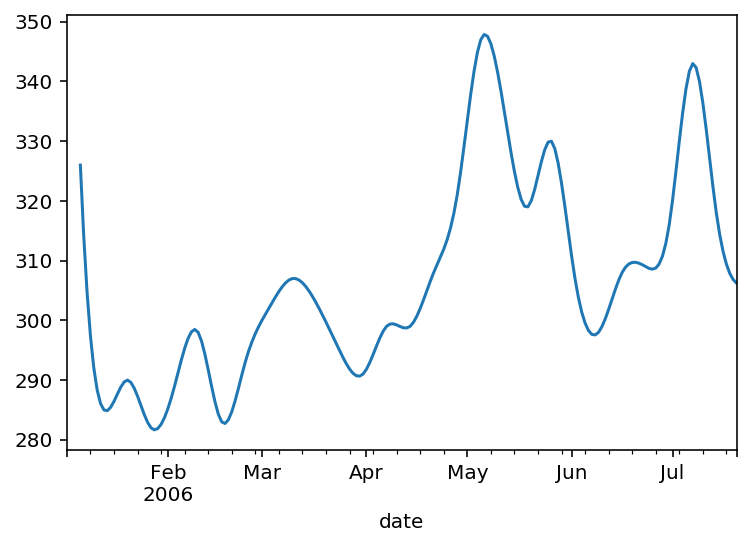

In [36]:
df['INJCJCIndex'].interpolate(method = 'cubic', limit_area = 'inside')[0:200].plot()

In [37]:
df['INJCJCIndex'].interpolate(method = 'cubic', limit_area = 'inside')[0:50]

date
2006-01-02           NaN
2006-01-03           NaN
2006-01-04           NaN
2006-01-05           NaN
2006-01-06    326.000000
2006-01-07    314.123680
2006-01-08    304.664374
2006-01-09    297.375710
2006-01-10    292.011313
2006-01-11    288.324811
2006-01-12    286.069831
2006-01-13    285.000000
2006-01-14    284.868944
2006-01-15    285.430291
2006-01-16    286.437666
2006-01-17    287.644698
2006-01-18    288.805013
2006-01-19    289.672238
2006-01-20    290.000000
2006-01-21    289.616287
2006-01-22    288.646533
2006-01-23    287.290534
2006-01-24    285.748086
2006-01-25    284.218983
2006-01-26    282.903023
2006-01-27    282.000000
2006-01-28    281.665909
2006-01-29    281.881537
2006-01-30    282.583871
2006-01-31    283.709898
2006-02-01    285.196604
2006-02-02    286.980976
2006-02-03    289.000000
2006-02-04    291.171974
2006-02-05    293.340440
2006-02-06    295.330251
2006-02-07    296.966259
2006-02-08    298.073318
2006-02-09    298.476281
2006-02-10    298.00

In [38]:
df['INJCJCIndex'].interpolate()[0:50]

date
2006-01-02           NaN
2006-01-03           NaN
2006-01-04           NaN
2006-01-05           NaN
2006-01-06    326.000000
2006-01-07    320.142857
2006-01-08    314.285714
2006-01-09    308.428571
2006-01-10    302.571429
2006-01-11    296.714286
2006-01-12    290.857143
2006-01-13    285.000000
2006-01-14    285.714286
2006-01-15    286.428571
2006-01-16    287.142857
2006-01-17    287.857143
2006-01-18    288.571429
2006-01-19    289.285714
2006-01-20    290.000000
2006-01-21    288.857143
2006-01-22    287.714286
2006-01-23    286.571429
2006-01-24    285.428571
2006-01-25    284.285714
2006-01-26    283.142857
2006-01-27    282.000000
2006-01-28    283.000000
2006-01-29    284.000000
2006-01-30    285.000000
2006-01-31    286.000000
2006-02-01    287.000000
2006-02-02    288.000000
2006-02-03    289.000000
2006-02-04    290.285714
2006-02-05    291.571429
2006-02-06    292.857143
2006-02-07    294.142857
2006-02-08    295.428571
2006-02-09    296.714286
2006-02-10    298.00

In [39]:
df.isna().sum().sum()

671094

In [40]:
df.interpolate().isna().sum().sum()

5755

In [41]:
df = df.interpolate(method = 'cubic', limit_area = 'inside')

근데 사잇값이 없는 경우는 어쩔 수 없이 bfill을 해야겠다.

In [42]:
df = df.fillna(method = 'bfill')

In [43]:
df = df.fillna(method = 'ffill')

In [44]:
df.isna().sum().sum()

0

In [45]:
df.to_csv('bloomberg_for_spline.csv')

In [46]:
df.reset_index(inplace = True)

In [47]:
date = df.date

In [48]:
df.drop('date', axis = 1, inplace = True)

In [49]:
df.head()

,index,KRXsemiconductor_close,FDTRIndex_x,FDTRIndex_y,USGG3MIndex,USGG10YRIndex,USTW$Index,INJCJCIndex,INJCSPIndex,USEMNCHGIndex,...,USCABALIndex,JNVNIYOYIndex,COSTNFR%Index,KOGNICNYIndex,KODFTOTYIndex,KOGNICUYIndex,EHCAUSIndex,KOGCGDPYIndex,PRODNFR%Index,KOGCSTOQIndex
0,0,1000.00,4.25,4.25,4.0736,4.3911,86.0274,326.0,2561.0,398.0,...,-198.2,13.6,5.2,3.0,-0.7,5.2,-5.67,5.6,2.9,0.6
1,1,1012.36,4.25,4.25,4.1144,4.3637,85.0983,326.0,2561.0,398.0,...,-198.2,13.6,5.2,3.0,-0.7,5.2,-5.67,5.6,2.9,0.6
2,2,1007.17,4.25,4.25,4.1798,4.3422,84.5642,326.0,2561.0,398.0,...,-198.2,13.6,5.2,3.0,-0.7,5.2,-5.67,5.6,2.9,0.6
3,3,991.68,4.25,4.25,4.1793,4.3519,84.7247,326.0,2561.0,398.0,...,-198.2,13.6,5.2,3.0,-0.7,5.2,-5.67,5.6,2.9,0.6
4,4,1008.15,4.25,4.25,4.1985,4.3733,84.3844,326.0,2561.0,398.0,...,-198.2,13.6,5.2,3.0,-0.7,5.2,-5.67,5.6,2.9,0.6


In [50]:
df.drop('index', axis = 1, inplace = True)

In [51]:
y_target = df['KRXsemiconductor_close']

In [52]:
X_data = df.drop('KRXsemiconductor_close', axis = 1, inplace = False)

In [95]:
X_data.head()

,FDTRIndex_x,FDTRIndex_y,USGG3MIndex,USGG10YRIndex,USTW$Index,INJCJCIndex,INJCSPIndex,USEMNCHGIndex,NFPPCHIndex,NFPTCHIndex,...,USCABALIndex,JNVNIYOYIndex,COSTNFR%Index,KOGNICNYIndex,KODFTOTYIndex,KOGNICUYIndex,EHCAUSIndex,KOGCGDPYIndex,PRODNFR%Index,KOGCSTOQIndex
0,1.703416,1.703416,1.793907,1.545836,0.587399,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704
1,1.703416,1.703416,1.819072,1.517702,0.469118,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704
2,1.703416,1.703416,1.859409,1.495627,0.401123,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704
3,1.703416,1.703416,1.859101,1.505587,0.421556,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704
4,1.703416,1.703416,1.870943,1.527559,0.378234,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)

In [58]:
lr = LinearRegression()

In [96]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [97]:
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [98]:
print('MSE: {0: .3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance Score : {0:3f}'.format(r2_score(y_test, y_pred)))

MSE:  2239.612, RMSE : 47.325
Variance Score : 0.990283


In [62]:
# intercept, coefficients 확인
print('절편 값 :', lr.intercept_)
print('회귀 계수 값 :', np.round(lr.coef_, 1))

절편 값 : -13870.990651271377
회귀 계수 값 : [-6.82260028e+10  6.82260027e+10  7.40000000e+00  1.16000000e+02
 -8.20000000e+00  1.00000000e-01  0.00000000e+00  0.00000000e+00
 -7.00000000e-01  3.00000000e-01  2.00000000e-01  3.30000000e+00
 -9.00000000e-01  1.70000000e+00 -3.00000000e+00  4.62000000e+01
  1.20000000e+00 -1.67900000e+02 -1.95000000e+01 -1.27000000e+01
  1.59400000e+02  1.18200000e+02  2.60000000e+00 -1.91000000e+01
 -1.90000000e+00 -9.58000000e+01 -4.00000000e-01  3.70000000e+00
  6.25000000e+01 -2.10000000e+00  2.86000000e+01 -2.47000000e+01
 -3.70000000e+00 -6.80000000e+00  4.40000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  2.00000000e-01 -0.00000000e+00
 -1.00000000e-01  1.41000000e+01 -1.49000000e+01 -2.31000000e+01
  1.50000000e+01  2.90000000e+00 -1.61000000e+01 -1.26000000e+01
  3.26000000e+01 -4.50000000e+00 -3.33000000e+01 -3.62000000e+01
  3.95000000e+01  3.00000000e+00 -3.35000000e+01  1.43000000e+01
 -1.58000000e+01 -1.00000000e+00  1.06000000e+01  1.8

In [63]:
# 피쳐별 회귀 계수 값으로 정렬
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

FDTRIndex_y      6.822600e+10
KOECPRCYIndex    3.887000e+02
OEUSKLARIndex    2.419000e+02
USHEYOYIndex     1.594000e+02
GDPCYOYIndex     1.554000e+02
                     ...     
CPTICHNGIndex   -2.361000e+02
KOECFCOYIndex   -3.161000e+02
CPUPXCHGIndex   -3.907000e+02
MGT2REIndex     -3.146400e+03
FDTRIndex_x     -6.822600e+10
Length: 140, dtype: float64

Standard Scaler를 써서 다시 해보기

In [64]:
y_target = df['KRXsemiconductor_close']

In [65]:
X_data = df.drop('KRXsemiconductor_close', axis = 1, inplace = False)

In [66]:
col_name = X_data.columns

In [67]:
X_data = StandardScaler().fit_transform(X_data)

In [68]:
X_data = pd.DataFrame(X_data, columns = col_name)

In [99]:
X_data.head()

,FDTRIndex_x,FDTRIndex_y,USGG3MIndex,USGG10YRIndex,USTW$Index,INJCJCIndex,INJCSPIndex,USEMNCHGIndex,NFPPCHIndex,NFPTCHIndex,...,USCABALIndex,JNVNIYOYIndex,COSTNFR%Index,KOGNICNYIndex,KODFTOTYIndex,KOGNICUYIndex,EHCAUSIndex,KOGCGDPYIndex,PRODNFR%Index,KOGCSTOQIndex
0,1.703416,1.703416,1.793907,1.545836,0.587399,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704
1,1.703416,1.703416,1.819072,1.517702,0.469118,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704
2,1.703416,1.703416,1.859409,1.495627,0.401123,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704
3,1.703416,1.703416,1.859101,1.505587,0.421556,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704
4,1.703416,1.703416,1.870943,1.527559,0.378234,-0.139676,-0.34784,0.944723,0.948862,0.768354,...,-2.097341,1.310912,0.87787,-0.168127,-1.791813,-0.042693,-2.041472,0.183274,0.64039,-0.600704


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)

In [71]:
lr = LinearRegression()

In [72]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [74]:
print('MSE: {0: .3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance Score : {0:3f}'.format(r2_score(y_test, y_pred)))

MSE:  2239.612, RMSE : 47.325
Variance Score : 0.990283


In [75]:
# intercept, coefficients 확인
print('절편 값 :', lr.intercept_)
print('회귀 계수 값 :', np.round(lr.coef_, 1))

절편 값 : 1656.5479464254645
회귀 계수 값 : [-6.9900e+01 -6.9900e+01  1.1500e+01  1.1330e+02 -6.4200e+01  1.5000e+01
  4.3600e+01  3.8000e+00 -1.4710e+02  6.1100e+01  1.0800e+01  4.8900e+01
 -1.6100e+01  1.5200e+01 -4.4000e+01  1.5300e+01  3.0000e-01 -2.1600e+01
 -2.4500e+01 -1.2600e+01  1.2550e+02  2.3930e+02  1.6100e+02 -4.5500e+01
 -2.6700e+01 -7.5190e+02 -9.9000e+00  2.3800e+01  4.9820e+02 -1.5400e+01
  5.6000e+00 -1.1340e+02 -3.6200e+01 -8.3600e+01  7.0000e+00  9.6400e+01
  9.6900e+01  2.7000e+01  1.0708e+03 -1.8710e+02 -2.2000e+00  1.2170e+02
 -1.9200e+02 -1.8490e+02  1.1480e+02  1.9900e+01 -1.0240e+02 -8.5600e+01
  1.4750e+02 -1.0400e+01 -6.5600e+01 -8.1600e+01  8.3800e+01  6.6000e+00
 -1.2580e+02  3.4200e+01 -1.8500e+01 -2.7000e+00  9.3000e+00  1.2100e+01
 -1.8100e+01 -1.1200e+01  5.9400e+01  1.0200e+01  3.4100e+01 -1.2970e+02
  5.0000e-01  1.1040e+02 -4.0000e+00 -1.0800e+02 -2.7400e+01 -1.4100e+01
 -2.8800e+01  8.2500e+01  1.0253e+03 -8.5480e+02  1.8241e+03  9.4250e+02
 -4.0280e+02  3

In [76]:
# 피쳐별 회귀 계수 값으로 정렬
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

SKLILIIndex      1824.1
OEUSKLARIndex    1716.1
NFPTIndex        1070.8
KOIPMSIndex      1025.3
SKLILCIndex       942.5
                  ...  
CPTICHNGIndex    -746.2
KOCPIIndex       -751.9
PIDSPINXIndex    -782.2
KOIPISAIndex     -854.8
GDPCUR$Index    -3666.8
Length: 140, dtype: float64

In [104]:
ridge = Ridge(alpha = 10)
ridge.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [105]:
y_pred = ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE: {0: .3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance Score : {0:3f}'.format(r2_score(y_test, y_pred)))

MSE:  3021.350, RMSE : 54.967
Variance Score : 0.986891


In [108]:
lasso = Lasso(alpha = 10)
lasso.fit(X_train, y_train)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [109]:
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE: {0: .3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance Score : {0:3f}'.format(r2_score(y_test, y_pred)))

MSE:  10225.182, RMSE : 101.120
Variance Score : 0.955637


In [81]:
# Ridge regression, alpha = 10
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

In [82]:
print(' 5 folds의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 3))
print(' 5 folds의 개별 RMSE scores : ', np.round(rmse_scores, 3))
print(' 5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds의 개별 Negative MSE scores :  [ -23125.996 -134920.086 -167300.765 -127135.41  -133723.35 ]
 5 folds의 개별 RMSE scores :  [152.072 367.315 409.024 356.561 365.682]
 5 folds의 평균 RMSE : 330.131


In [83]:
# alpha 값 변경에 따른 RMSE 체크
alphas = [0, 0.1, 1, 10, 100]

# alpha list 값 변경해가며 평균 RMSE 측정
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    
    # cross validation score를 이용해서 5 fold 의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 fold의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5 fold의 평균 RMSE : 159510.364
alpha 0.1일 때 5 fold의 평균 RMSE : 580.837
alpha 1일 때 5 fold의 평균 RMSE : 442.510
alpha 10일 때 5 fold의 평균 RMSE : 330.131
alpha 100일 때 5 fold의 평균 RMSE : 344.145


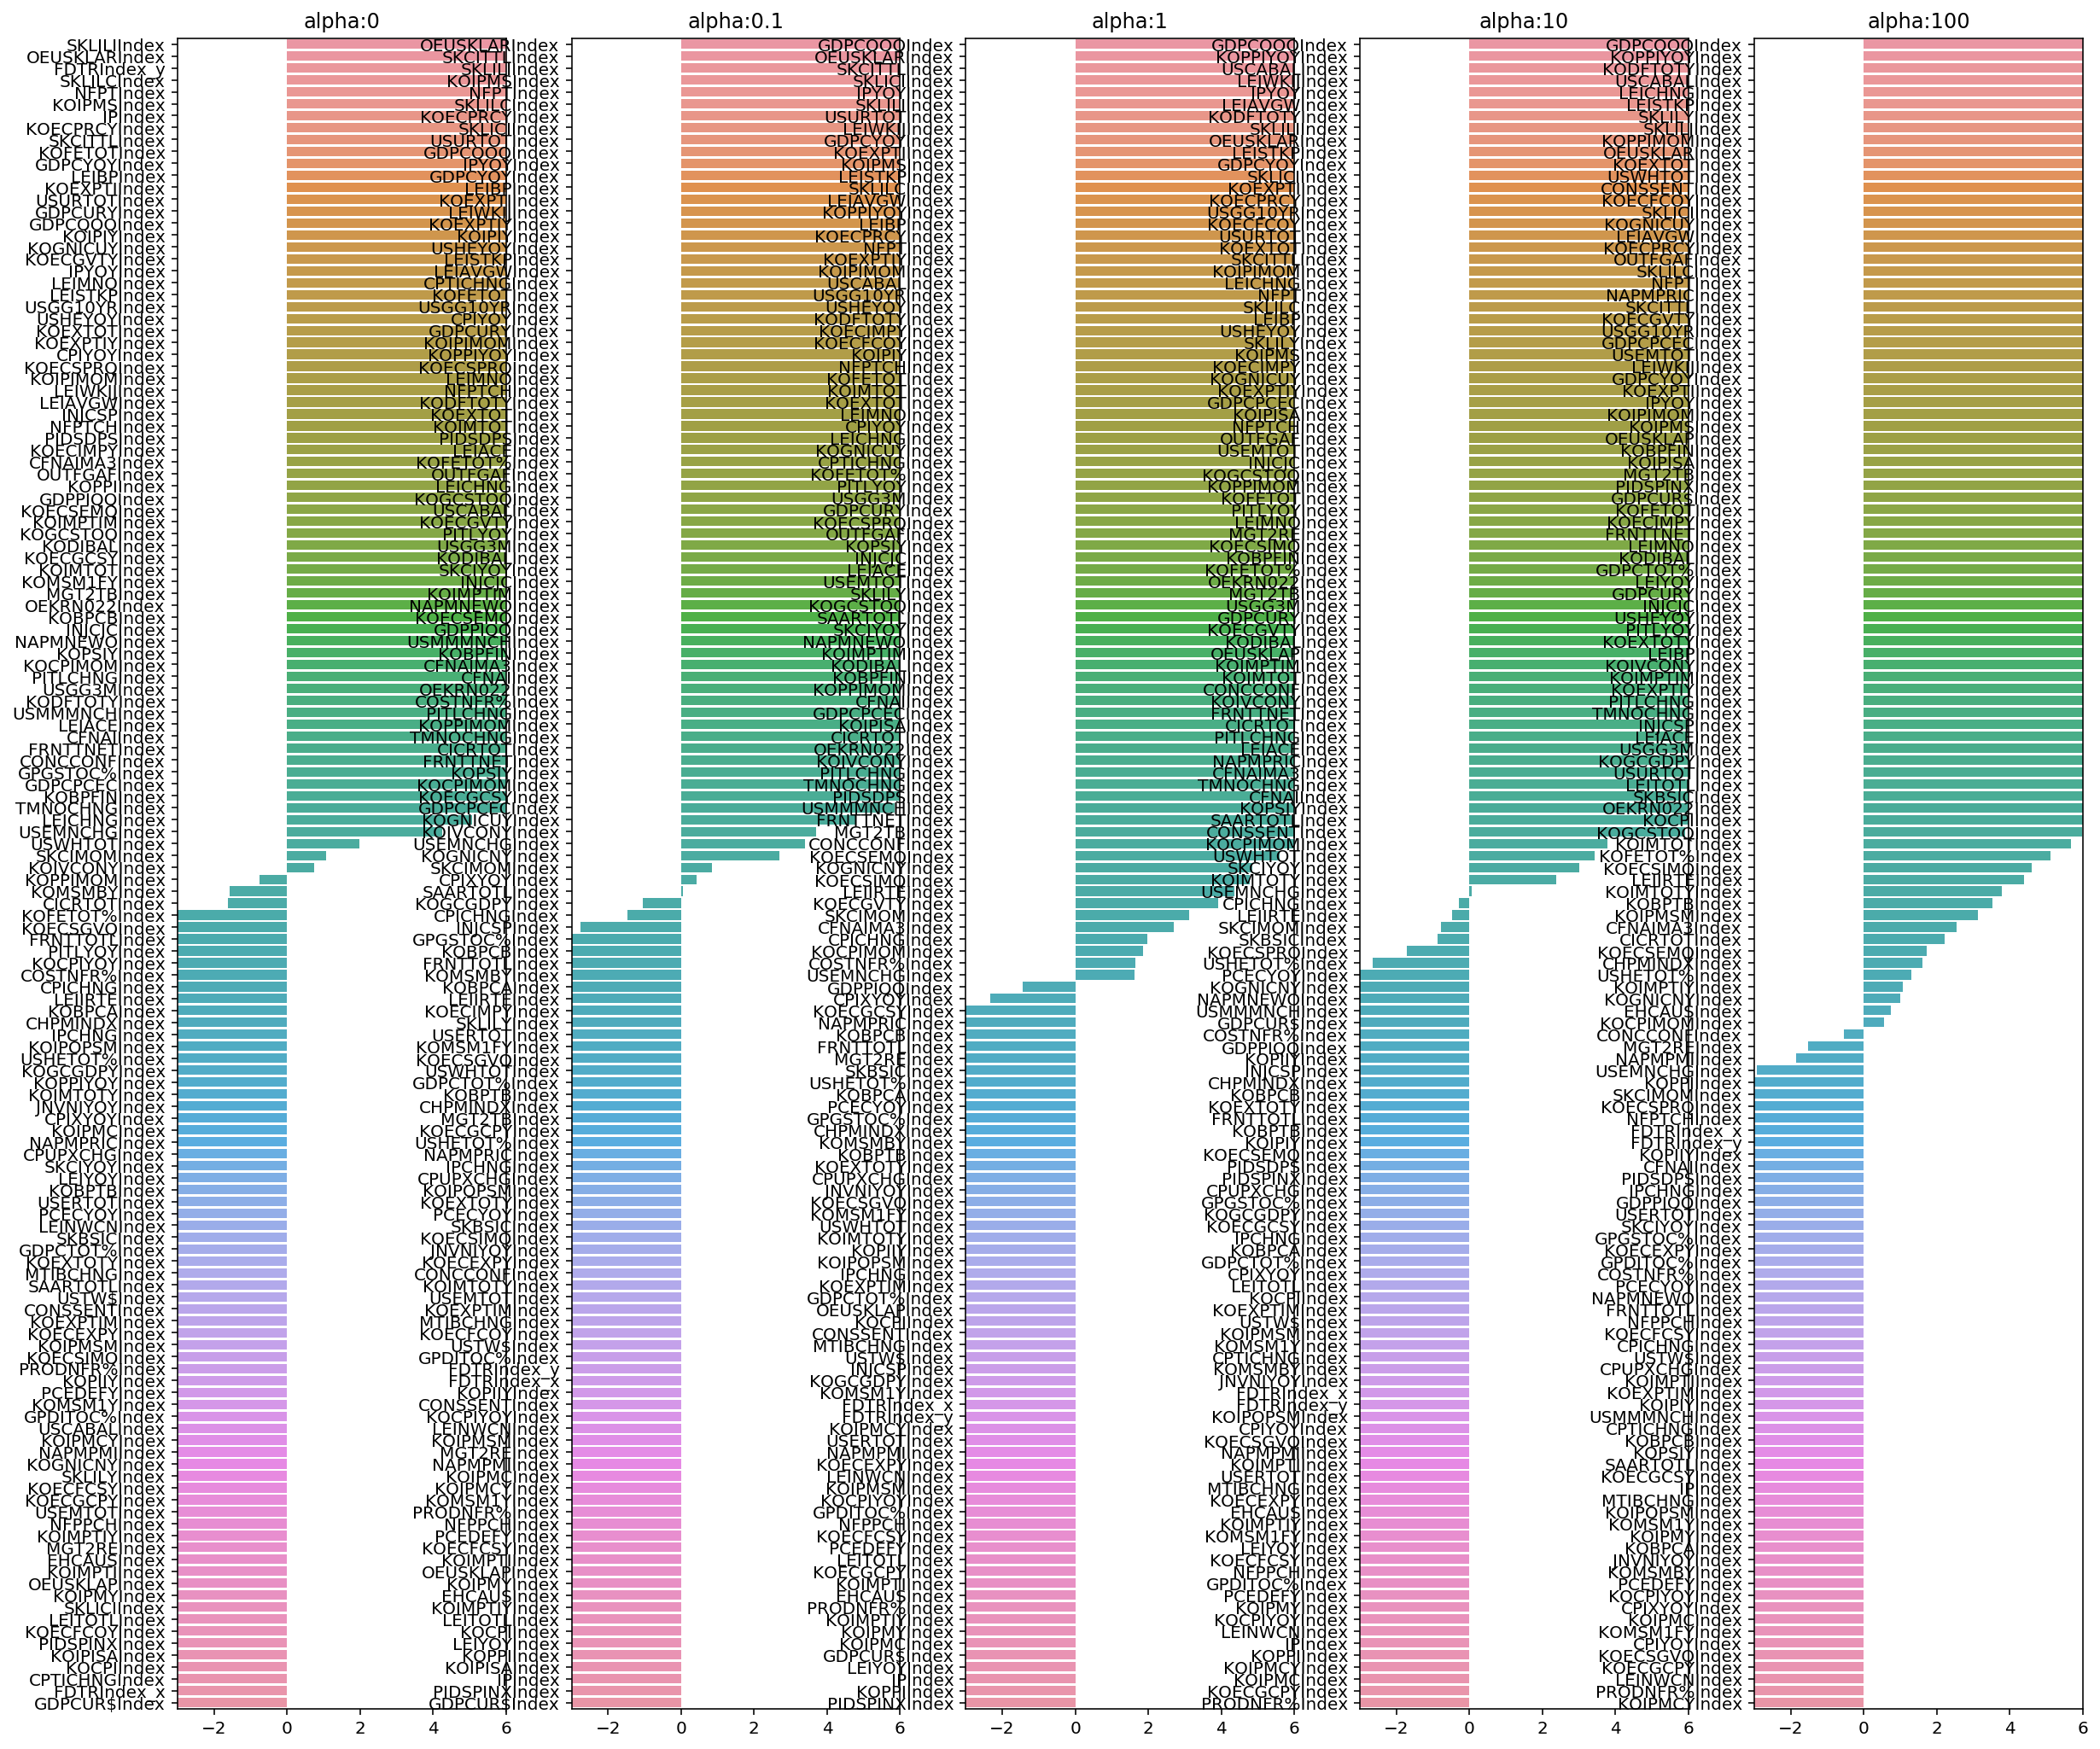

In [84]:
# alpha 값의 변화에 따른 피쳐의 회귀 계수값을 시각화
# 5열 matplotlib 축 생성
fig, axs = plt.subplots(figsize = (20, 18), nrows = 1, ncols = 5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 
coeff_df = pd.DataFrame()

# alpha 리스트 값을 차례로 입력해 회귀계수 값 시각화 및 데이터 저장
# pos는 axis 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    # alpha 에 따른 피쳐별로 회귀 계수를 Series로 변환하고 이를 DataFrame 컬럼으로 추가
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
    colname = 'alpha:' + str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. sorting
    coeff = coeff.sort_values(ascending = False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x = coeff.values, y = coeff.index, ax = axs[pos])

plt.show()
    

In [85]:
# alpha값을 증가시킬 수록 회귀 계쑤값이 작아지는 것 확인
# DataFrame에 저장된 alpha값의 변화에 따른 Ridge 회귀계수값 확인
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:' + str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
SKLILIIndex,1651.070188,440.939776,189.628003,74.881194,39.463937
OEUSKLARIndex,1634.257438,843.327679,237.370445,74.765293,36.188084
FDTRIndex_y,1529.866687,-63.752671,-59.778769,-30.103191,-6.256131
SKLILCIndex,1482.481314,357.521397,127.140292,45.538438,25.270933
NFPTIndex,1008.527275,416.281200,106.655792,46.123512,23.662425
...,...,...,...,...,...
KOIPISAIndex,-828.146511,-277.844629,14.607903,29.461144,18.927639
KOCPIIndex,-850.278156,-245.202749,-40.430837,-23.135076,6.343577
CPTICHNGIndex,-908.770793,107.431559,38.284490,-26.775242,-19.196790
FDTRIndex_x,-1671.395383,-63.752671,-59.778769,-30.103191,-6.256131


In [86]:
coeff_df['alpha:100'].sort_values(ascending = False)

GDPCQOQIndex      77.018888
KOPPIYOYIndex     62.367964
KODFTOTYIndex     53.658803
USCABALIndex      50.575191
LEICHNGIndex      48.428147
                    ...    
KOECSGVQIndex    -40.086091
KOECGCPYIndex    -42.270835
LEINWCNIndex     -45.080345
PRODNFR%Index    -47.465933
KOIPMCYIndex    -101.226269
Name: alpha:100, Length: 140, dtype: float64

In [87]:
coeff_df[coeff_df['alpha:100'] > 0]['alpha:100'].sort_values(ascending = False)

GDPCQOQIndex     77.018888
KOPPIYOYIndex    62.367964
KODFTOTYIndex    53.658803
USCABALIndex     50.575191
LEICHNGIndex     48.428147
                   ...    
USHETOT%Index     1.313263
KOIMPTIYIndex     1.079658
KOGNICNYIndex     0.989811
EHCAUSIndex       0.746437
KOCPIMOMIndex     0.549459
Name: alpha:100, Length: 83, dtype: float64

In [88]:
len(coeff_df[coeff_df['alpha:100'] > 0]['alpha:100'].sort_values(ascending = False))

83

그러니까 여기까지 정리하면 StandardScaler를 적용했을 때,  
일단 분석에 유의미한 영향을 주는 회귀 계수 0이상의 변수만 봤을 때 그 갯수는 65개임

In [89]:
a = coeff_df[coeff_df['alpha:100'] > 0]['alpha:100']

In [90]:
a = a.index

In [91]:
a = list(a)

In [92]:
a

['USGG3MIndex',
 'USGG10YRIndex',
 'INJCJCIndex',
 'INJCSPIndex',
 'OUTFGAFIndex',
 'KOIMTOTYIndex',
 'KOFETOT%Index',
 'KOEXTOTYIndex',
 'KOCPIMOMIndex',
 'USHETOT%Index',
 'USHEYOYIndex',
 'USURTOTIndex',
 'KOFETOTIndex',
 'NAPMPRICIndex',
 'KOCPIIndex',
 'SKCITTLIndex',
 'CHPMINDXIndex',
 'USWHTOTIndex',
 'SKBSICIndex',
 'CONSSENTIndex',
 'LEIWKIJIndex',
 'KOEXTOTIndex',
 'KOIMTOTIndex',
 'NFPTIndex',
 'USEMTOTIndex',
 'KOIVCONYIndex',
 'KOEXPTIYIndex',
 'KOIMPTIYIndex',
 'LEIYOYIndex',
 'IPYOYIndex',
 'KOIPMSMIndex',
 'KOIPIMOMIndex',
 'TMNOCHNGIndex',
 'KOIMPTIMIndex',
 'LEIIRTEIndex',
 'PITLYOYIndex',
 'PITLCHNGIndex',
 'KOPPIYOYIndex',
 'CFNAIMA3Index',
 'LEICHNGIndex',
 'LEIACEIndex',
 'SKLILYIndex',
 'KOPPIMOMIndex',
 'KOIPMSIndex',
 'KOIPISAIndex',
 'SKLILIIndex',
 'SKLILCIndex',
 'SKLICIIndex',
 'LEIAVGWIndex',
 'LEITOTLIndex',
 'KOEXPTIIndex',
 'LEISTKPIndex',
 'LEIBPIndex',
 'PIDSPINXIndex',
 'LEIMNOIndex',
 'KOBPFINIndex',
 'KOBPTBIndex',
 'KODIBALIndex',
 'FRNTTNETIndex'

In [101]:
rf = RandomForestRegressor(random_state = 0, n_estimators = 1000)

In [102]:
X_data = df.drop('KRXsemiconductor_close', axis = 1, inplace = False)
y_target = df['KRXsemiconductor_close']

In [103]:
neg_mse_scores = cross_val_score(rf, X_data, y_target,
                                                    scoring = "neg_mean_squared_error", cv = 5)

In [104]:
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

In [105]:
print(' 5 교차 검증의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores :  [-108452.42 -104390.39  -98472.47 -246378.04 -408932.11]
 5 교차 검증의 개별 RMSE scores :  [329.32 323.1  313.8  496.36 639.48]
 5 교차 검증의 평균 RMSE : 420.412


In [106]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = "neg_mean_squared_error",
                                    cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print("model name :", model.__class__.__name__)
    print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

In [114]:
dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

In [115]:
# 트리 기반 회귀 모델을 반복하며 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

model name : DecisionTreeRegressor
5 교차 검증의 평균 RMSE : 464.234
model name : RandomForestRegressor
5 교차 검증의 평균 RMSE : 420.412
model name : GradientBoostingRegressor
5 교차 검증의 평균 RMSE : 410.624
[11:46:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:47:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:48:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:49:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model name : XGBRegressor
5 교차 검증의 평균 RMSE : 389.605
model name : LGBMRegressor
5 교차 검증의 평균 RMSE : 390.629


In [ ]:
# regression tree class feature importance 
#rf_reg = RandomForestRegressor(n_estimators = 1000)
#rf_reg.fit(X_data, y_target)

In [116]:
feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns)
feature_series = feature_series.sort_values(ascending = False)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [117]:
sns.barplot(x = feature_series, y = feature_series.index)

NameError: name 'feature_series' is not defined